## LEVEL 1: Data Retreival & Preprocessing
Get all the packages needed for fetching & preprocessing

In [2]:
!jupyter nbconvert --to script descEmbedder.ipynb

[NbConvertApp] Converting notebook descEmbedder.ipynb to script
[NbConvertApp] Writing 18694 bytes to descEmbedder.py


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The following data is a set of English descriptions of roughly 15,000 companies publicly listed in the U.S. stock exchanges. The data itself is from the financialmodelingprep.com API. I aggregated them to my database, so I had to export it as csv. The following is the sql query that created the csv file:

SELECT Symbol, companyName, description, industry, sector, ipoDate
FROM profile_v2
WHERE country = "US"
	AND isFund = 0
	AND isEtf = 0
	AND currency = "USD"
	AND (exchangeShortName = "NASDAQ" OR exchangeShortName = "NYSE")
GROUP BY companyName
ORDER BY symbol ASC


In [2]:
df = pd.read_csv('./database/profile_v2.csv') # csv file created by the query above
print(df.head(5))
print(df.count())

   Unnamed: 0 Symbol                   companyName  \
0           0      A    Agilent Technologies, Inc.   
1           1     AA             Alcoa Corporation   
2           2    AAC  Ares Acquisition Corporation   
3           3   AACI    Armada Acquisition Corp. I   
4           4  AACQU       Artius Acquisition Inc.   

                                         description                industry  \
0  Agilent Technologies, Inc. provides applicatio...  Diagnostics & Research   
1  Alcoa Corporation, together with its subsidiar...                Aluminum   
2  Ares Acquisition Corporation does not have sig...         Shell Companies   
3  Armada Acquisition Corp. I focuses on effectin...         Shell Companies   
4                                                NaN                     NaN   

               sector     ipoDate  
0          Healthcare  1999-11-18  
1     Basic Materials  2016-11-01  
2  Financial Services  2021-03-25  
3  Financial Services  2021-11-10  
4          Tec

We are definitely seeing some null values.

In [3]:
print(pd.isna(df).sum(0))

Unnamed: 0       0
Symbol           0
companyName      0
description    169
industry       256
sector         170
ipoDate         93
dtype: int64


Luckily, the number of rows with null values are small enough, so we can get rid of rows that have null in any columns without worrying about trashing more than half of our dataset.

In [4]:
df = df.dropna(axis=0, how='any')  ## 0 == index or rows, 1 == column. We need to get rid of rows.
print(df)
print(pd.isna(df).sum(0))

      Unnamed: 0 Symbol                             companyName  \
0              0      A              Agilent Technologies, Inc.   
1              1     AA                       Alcoa Corporation   
2              2    AAC            Ares Acquisition Corporation   
3              3   AACI              Armada Acquisition Corp. I   
5              5   AADI                   Aadi Bioscience, Inc.   
...          ...    ...                                     ...   
5542        5542   ZVSA              ZyVersa Therapeutics, Inc.   
5543        5543   ZWRK                Z-Work Acquisition Corp.   
5544        5544    ZWS  Zurn Elkay Water Solutions Corporation   
5545        5545   ZYNE           Zynerba Pharmaceuticals, Inc.   
5546        5546   ZYXI                             Zynex, Inc.   

                                            description  \
0     Agilent Technologies, Inc. provides applicatio...   
1     Alcoa Corporation, together with its subsidiar...   
2     Ares Acquisi

Let's check the distribution of the description length.

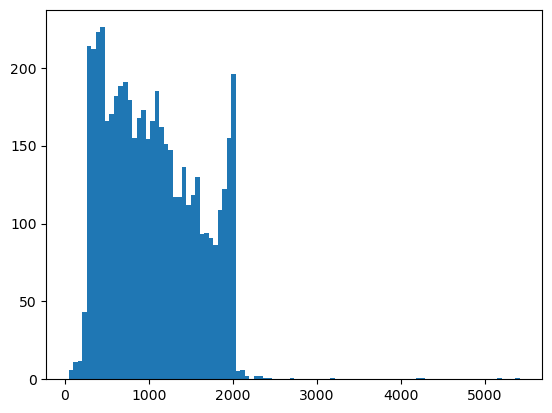

In [5]:
df['desc_length'] = df['description'].str.len()
plt.hist(df['desc_length'], bins=100)
plt.show()

We see that there is a cliff around 2000. We can deduce from this fact that SEC(Securities and Exchange Commission) limits characters up to 2000. Let's get rid of those outliers.

In [6]:
df = df[df['desc_length'] <= 2000]

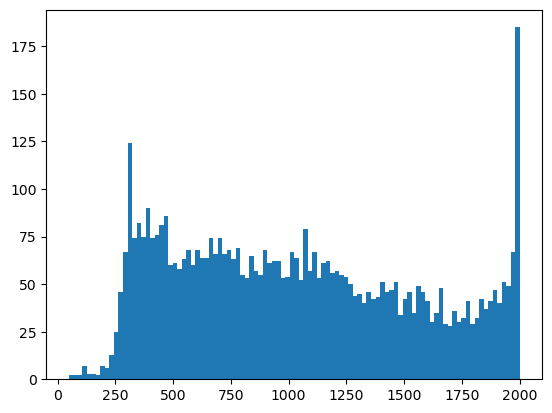

Unnamed: 0     5149
Symbol         5149
companyName    5149
description    5149
industry       5149
sector         5149
ipoDate        5149
desc_length    5149
dtype: int64


In [7]:
plt.hist(df['desc_length'], bins=100)
plt.show()
print(df.count())

Now we are left with about 5000 rows.

One last thing we might consider doing is cleaning up the description strings(all to lowercase, get rid of unnecessary spaces, etc. etc.). Traditionally, this is a good practice. However, there are two good reasons not to do so. One, we are going to apply a neural network language model that is designed to handle such "noise" robustly. Two, there is a risk of removing essential information during the string clean-up process, such as proper nouns (Apple and apple may mean two different things in this dataset). Therefore, we will leave them as-is and proceed to the next step.

Next, we get three-year worth of historical daily price data. Following sql query was used to make close.csv:

SELECT date, symbol, close
FROM cv
WHERE symbol in (SELECT symbol FROM us_company_profile)
	AND date BETWEEN date('2020-01-01') AND date('2023-01-01'),

where us_company_profile is equivalent to profile_v2.csv that we read in the beginning.

In [8]:
close_prices = pd.read_csv('./database/close.csv',index_col=['symbol', 'date'])['close']
print(close_prices)

symbol  date               
A       2020-01-01 00:00:00    83.155304
        2020-01-02 00:00:00    83.779144
        2020-01-03 00:00:00    82.433990
        2020-01-04 00:00:00    82.433990
        2020-01-05 00:00:00    82.433990
                                 ...    
ZYXI    2022-12-27 00:00:00    13.760000
        2022-12-28 00:00:00    13.880000
        2022-12-29 00:00:00    13.870000
        2022-12-30 00:00:00    13.910000
        2022-12-31 00:00:00    13.910000
Name: close, Length: 4887970, dtype: float64


The following code calculates mean and variance of log daily returns(log(today) - log(yesterday)) of each company. Why log returns? In short, they are "better" versions of percent changes, and we care more about percent changes than absolute differences when it comes to stocks. For more in-depth explanation, refer to this [article](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).

In [9]:
close_prices = close_prices.unstack(level=0) # unstacking such that rows are dates, columns are close prices of each symbol
print(close_prices)

symbol                        A         AA    AAC   AACI  AACQU   AADI  AAIC  \
date                                                                           
2020-01-01 00:00:00   83.155304  21.144423    NaN    NaN    NaN   9.36  5.57   
2020-01-02 00:00:00   83.779144  21.055954    NaN    NaN    NaN   9.60  5.54   
2020-01-03 00:00:00   82.433990  21.134590    NaN    NaN    NaN   9.60  5.52   
2020-01-04 00:00:00   82.433990  21.134590    NaN    NaN    NaN   9.60  5.52   
2020-01-05 00:00:00   82.433990  21.134590    NaN    NaN    NaN   9.60  5.52   
...                         ...        ...    ...    ...    ...    ...   ...   
2022-12-27 00:00:00  148.500885  44.521076  10.09  10.06    NaN  11.99  2.86   
2022-12-28 00:00:00  147.051102  43.469086  10.08  10.10    NaN  12.03  2.83   
2022-12-29 00:00:00  150.030060  46.208233  10.09  10.10    NaN  12.58  2.92   
2022-12-30 00:00:00  148.821777  45.126469  10.07  10.12    NaN  12.83  2.93   
2022-12-31 00:00:00  148.821777  45.1264

In [10]:
close_prices[close_prices <= 0] = pd.NA # turn any nonpositive numbers to Null values. We can't have negative price in stocks!
close_prices = close_prices.dropna(how='all', axis=1) # now drop all symbols that have no values at all
close_prices = np.log(close_prices) # apply log to every value
close_prices = close_prices.diff() # calculate difference

5098
5098


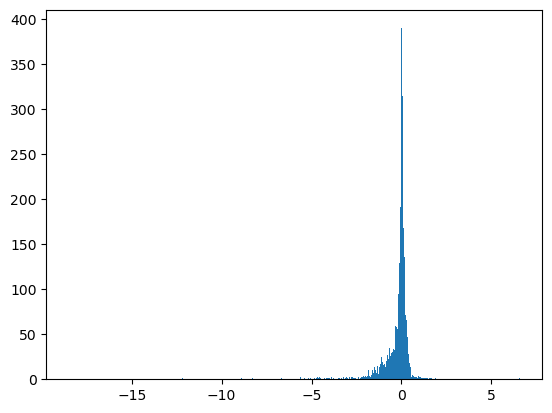

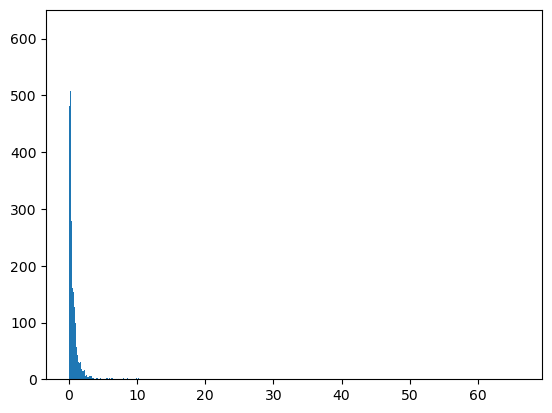

In [11]:
mean_log_return = close_prices.mean() * 365 # multiplying by 365 to annualize them. Also, it helps preventing floating point errors.
mean_log_return.name = "mean_log_return"
var_log_return = close_prices.var() * 365
var_log_return.name = "var_log_return"
print(len(mean_log_return))
print(len(var_log_return))
plt.hist(mean_log_return, bins=1000)
plt.show()
plt.hist(var_log_return, bins=1000)
plt.show()


The histogram tells us that outliers are really huge, which makes the dataset really ugly. Let's remove them.

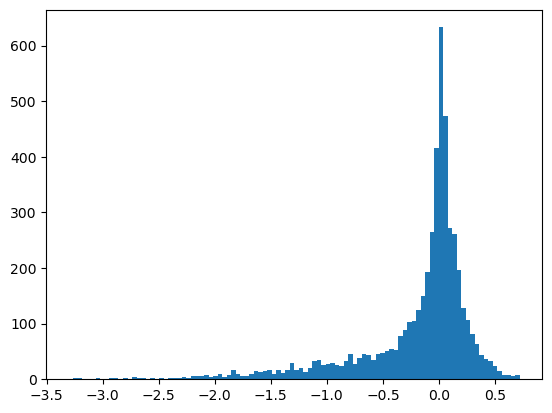

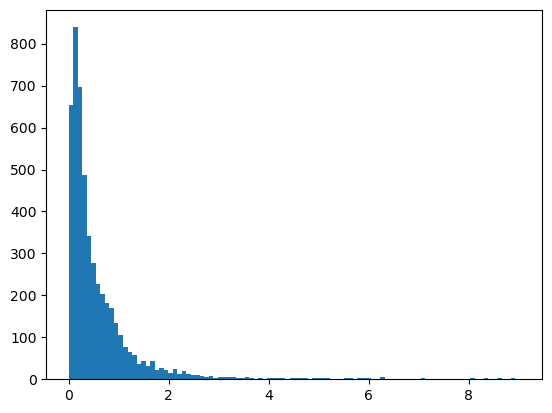

4996
4995


In [12]:
def remove_outliers(df, quantile = 0.01):
    q_low = df.quantile(quantile)
    q_hi  = df.quantile(1 - quantile)
    return df[(df < q_hi) & (df > q_low)]

mean_log_return = remove_outliers(mean_log_return)
var_log_return = remove_outliers(var_log_return)

plt.hist(mean_log_return, bins=100)
plt.show()
plt.hist(var_log_return, bins=100)
plt.show()

print(len(mean_log_return))
print(len(var_log_return))

## LEVEL 2: model selection, training & inference
Our primary goal is to find similarities between companies in terms of their business descriptions. Now, we will turn all the descriptions into 768 dimensional "sentence vectors" via SBERT. By doing so, we can treat company descriptions as if they are vectors in a vector space: add, subtract, multiply, dot, measure distance, etc., etc.. In addition to that, I will demonstrate K-means clustering and return prediction as well.

In [13]:
from sentence_transformers import SentenceTransformer, util

# largest model available in the package
#
model = SentenceTransformer('all-mpnet-base-v2')

In [14]:
data_np = df[["companyName", "description", "Symbol"]].to_numpy()
print(data_np[:5])

[['Alcoa Corporation'
  'Alcoa Corporation, together with its subsidiaries, produces and sells bauxite, alumina, and aluminum products in the United States, Spain, Australia, Iceland, Norway, Brazil, Canada, and internationally. The company operates through three segments: Bauxite, Alumina, and Aluminum. It engages in bauxite mining operations; and processes bauxite into alumina and sells it to customers who process it into industrial chemical products, as well as aluminum smelting and casting businesses. The company offers primary aluminum in the form of alloy ingot or value-add ingot to customers that produce products for the transportation, building and construction, packaging, wire, and other industrial markets. In addition, it owns hydro power plants that generates and sells electricity in the wholesale market to traders, large industrial consumers, distribution companies, and other generation companies. The company was formerly known as Alcoa Upstream Corporation and changed its 

Now, This is where the magic happens. We can use the pretrained SentenceTransformer to change all those descriptions into "sentence vectors." This is convenient, but I have to admit that training a model is part of the fun of data science. We will definitely train a neural network to estimate something very interesting later.

In [15]:
embeddings = model.encode(data_np[:, 1])
print(embeddings[:5])
print(embeddings.shape)

[[ 0.01157187 -0.00701198 -0.04583892 ... -0.01335563 -0.01446298
   0.01228112]
 [ 0.05611649  0.02873488 -0.00445818 ...  0.01920705 -0.04479878
  -0.03358073]
 [ 0.08134606  0.06038287 -0.00352302 ...  0.00046919 -0.00630195
  -0.01434242]
 [ 0.0472974   0.06014708 -0.01924544 ... -0.01802283 -0.08088685
  -0.00468394]
 [ 0.01007729  0.02849333 -0.01930294 ... -0.0083851  -0.02876542
  -0.03548003]]
(5149, 768)


Running PCA to make the data easier to visualize

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=100)

pca_embeddings = pca.fit_transform(embeddings)
var_ratio = pca.explained_variance_ratio_
print(pca_embeddings.shape)

(5149, 100)


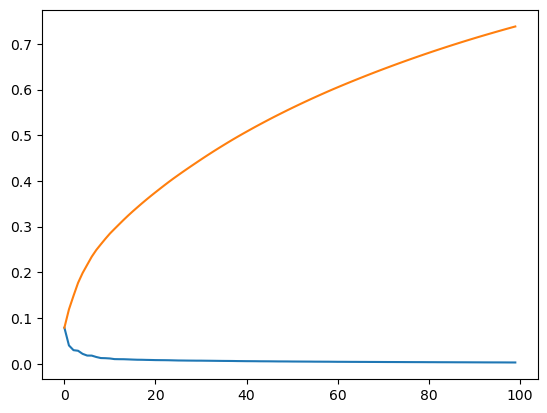

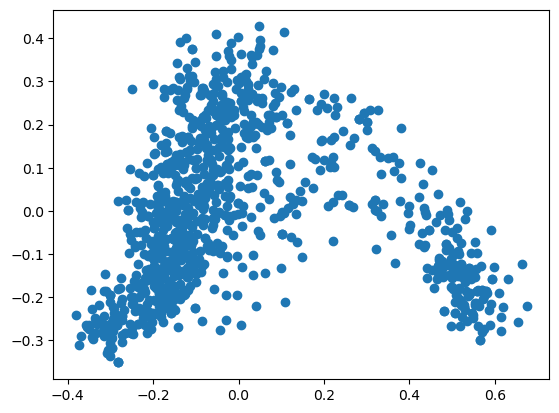

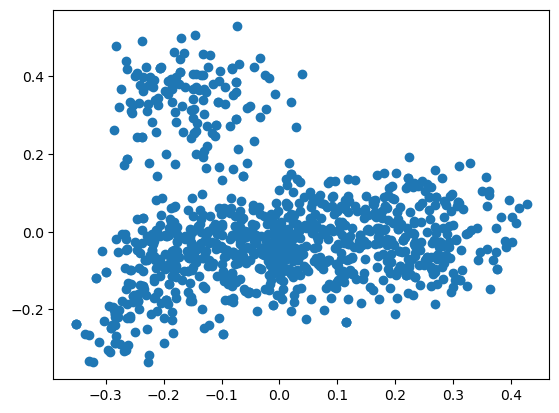

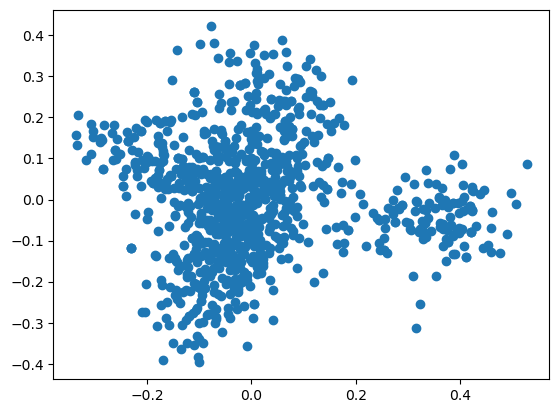

In [17]:
plt.plot(var_ratio)
plt.plot(np.cumsum(var_ratio))
plt.show()

pca_sample = pca_embeddings[np.random.randint(pca_embeddings.shape[0], size=1000)]  # random sample 1000 data points
plt.scatter(pca_sample[:, 0], pca_sample[:, 1])
plt.show()

plt.scatter(pca_sample[:, 1], pca_sample[:, 2])
plt.show()

plt.scatter(pca_sample[:, 2], pca_sample[:, 3])
plt.show()

From the scatterplots, we can definitely see some clustering action going on, perhaps by industry or sector. This is a good sign that tells us we are heading to the right direction.

## Applications

### 1. Semantic Search

In [18]:
# given a string, prints top n company descriptions that are semantically similar to the given string.
def semantic_search(string, top=10, use_pca=True):
    if use_pca:
        my_idea = pca.transform([model.encode(string)])[0]
        my_idea = [float(i) for i in my_idea]
        search_result = util.cos_sim(my_idea, pca_embeddings)[0]
    else:
        my_idea = model.encode(string)
        search_result = util.cos_sim(my_idea, embeddings)[0]

    rank = []
    for i in range(len(data_np)):
        rank.append([search_result[i], data_np[i]])
        rank = sorted(rank, key=lambda x: x[0], reverse=True)
    print(rank[:top])

#given a symbol, print its peers calculated by cosine similarity
def find_peers_of(symbol, top=10, use_pca=True):
    desc = df[df['Symbol'] == symbol]['description'].tolist()
    desc = desc[0]
    semantic_search(desc, top=top, use_pca=use_pca)

In [19]:
# try it yourself!
semantic_search("I'm going to cure cancer.", top=10, use_pca=True)

[[tensor(0.6134), array(['Precision BioSciences, Inc.',
       'Precision BioSciences, Inc., a clinical stage gene editing company, develops in vivo gene editing and ex vivo allogeneic CAR T therapies in the United States. It offers ARCUS, a genome editing platform to cure genetic disorders. The company also provides Ex vivo Allogeneic CAR T Immunotherapy, a form of immunotherapy in which T cell, a specific type of immune cell is genetically engineered to recognize and kill cancer cells; PBCAR0191, which is in Phase 1/2a clinical trial in adult patients with R/R NHL or R/R B-cell precursor acute lymphoblastic leukemia, or B-ALL; PBCAR19B, an anti-CD19 CAR T candidate built on the stealth cell platform utilizing a single-step gene edit to minimize the risk of chromosome abnormalities; and PBCAR269A, an investigational allogeneic CAR T immunotherapy targeting BCMA for the treatment of R/R multiple myeloma. The company has development and commercial license agreement with Les Laboratoires

In [20]:
find_peers_of('AAPL', use_pca=True) # see how use_pca parameter changes the output. It is subtle, but there is a difference.

[[tensor(0.9997), array(['Apple Inc.',
       'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. In addition, the company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; AirPods Max, an over-ear wireless headphone; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, HomePod, and iPod touch. Further, it provides AppleCare support services; cloud services store services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. Additionally, the company offers various services, such as Apple Arcade, a game subscription service; Apple Music, which offers users a curated listening experience with on-demand radio stations; Apple News+, a subscri

From our samples, we can see that our model does not deviate much from our intuition, but it outputs some unexpected peers as well. I will introduce a quantitative metric in Level 3 that can validate these results. As of now, let's focus on answering questions.

### 2. Clustering even further?

Here, we will demonstrate clustering using K-means clustering algorithm.

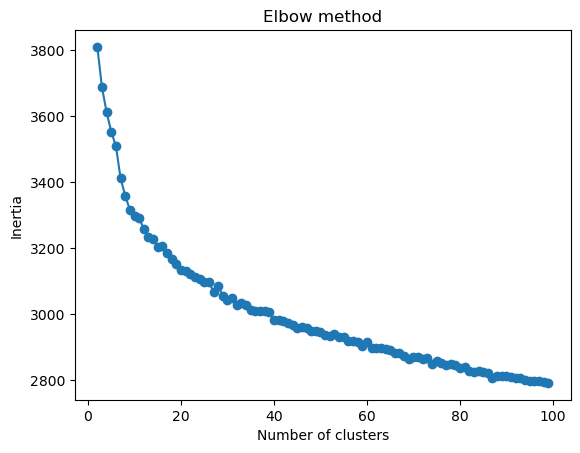

In [21]:
from sklearn.cluster import KMeans

inertias = []

for i in range(2, 100): # elbow method to find good cluster
    kmeans = KMeans(n_clusters= i, n_init='auto')
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 100), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Hmm, when the plot looks like this, it often implies that there is no obvious clustering going on. Let's try it again on PCA-transformed data.

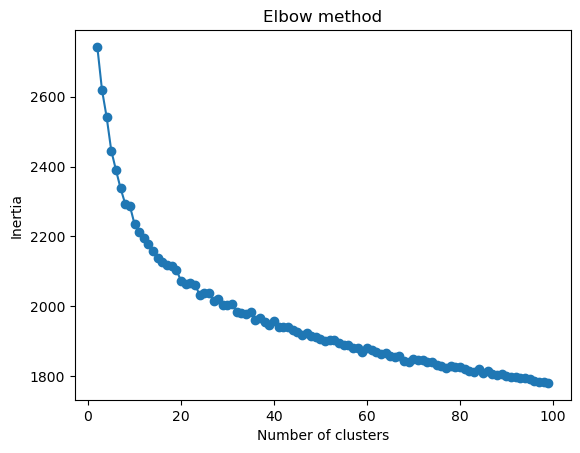

In [22]:
inertias = []

for i in range(2, 100): # elbow method to find good cluster
    kmeans = KMeans(n_clusters= i, n_init='auto')
    kmeans.fit(pca_embeddings)
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 100), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Still no good. Maybe we should try Gaussian Mixture Model since the scatter plots above showed elliptical clusters. Here, we are using [silhouette score](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) that essentially measures how well datapoints are clustered for a given number of clusters. Closer to 1, the better.


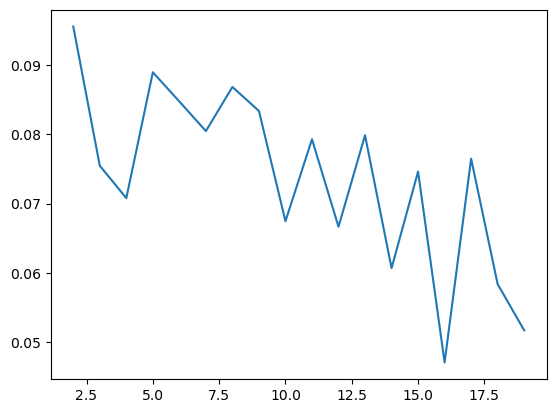

In [23]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
sil_scores = []
n_clusters = range(2, 20)
for n in n_clusters:
    gmm = GaussianMixture(n_components=n)
    gmm.fit(pca_embeddings)
    labels = gmm.predict(pca_embeddings)
    sil = silhouette_score(pca_embeddings, labels, sample_size=500)
    sil_scores.append(sil)

plt.plot(n_clusters, sil_scores)
plt.show()



Even the gaussian mixture model could not find a good cluster set. From this result, we learned two lessons: it is hard to cluster companies, and eyeballing on scatter plots will not always give you right answers. It may be due to the curse of dimensionality of the embedding space; even reduced to 100 dimensions with PCA, it might have been too many to handle for the models.

Well, it is disappointing, but at least we learned something. Let's move on.

### 3. (Try to) predict stock returns and volatility from descriptions

In [24]:
# inner join description table with log return tables
desc_w_return = df.merge(mean_log_return, how="inner", left_on="Symbol", right_on="symbol")
desc_w_return = desc_w_return.merge(var_log_return, how="inner", left_on="Symbol", right_on="symbol")
dataset = desc_w_return[['Symbol', 'description', 'mean_log_return', 'var_log_return']] ## aggregate everything to dataset dataFrame
print(dataset)

     Symbol                                        description  \
0        AA  Alcoa Corporation, together with its subsidiar...   
1       AAC  Ares Acquisition Corporation does not have sig...   
2      AACI  Armada Acquisition Corp. I focuses on effectin...   
3      AADI  Aadi Bioscience, Inc., a clinical-stage biopha...   
4      AAIC  Arlington Asset Investment Corp. (NYSE: AAIC) ...   
...     ...                                                ...   
4691   ZVSA  ZyVersa Therapeutics, Inc., a clinical stage b...   
4692   ZWRK  Z-Work Acquisition Corp. does not have signifi...   
4693    ZWS  Zurn Elkay Water Solutions Corporation designs...   
4694   ZYNE  Zynerba Pharmaceuticals, Inc. operates as a cl...   
4695   ZYXI  Zynex, Inc., through its subsidiaries, designs...   

      mean_log_return  var_log_return  
0            0.252698        0.501016  
1            0.011335        0.001669  
2            0.032680        0.005001  
3            0.105114        0.843845  
4      

In [25]:
dataset.loc[:, 'description'] = dataset.description.apply(lambda x: model.encode(x))
print(dataset)

     Symbol                                        description  \
0        AA  [0.011571882, -0.0070119635, -0.045838922, 0.0...   
1       AAC  [0.056116547, 0.028734839, -0.0044581755, -0.0...   
2      AACI  [0.08134604, 0.060382858, -0.0035230091, -0.05...   
3      AADI  [0.047297433, 0.06014711, -0.01924543, -0.0380...   
4      AAIC  [0.010077293, 0.028493337, -0.01930295, 0.0288...   
...     ...                                                ...   
4691   ZVSA  [0.036785394, -0.036170714, 0.029631425, -0.00...   
4692   ZWRK  [0.024548067, 0.049094517, 0.026254058, -0.050...   
4693    ZWS  [-0.022863707, -0.0068425247, -0.022016205, 0....   
4694   ZYNE  [0.046096846, 0.0030828528, 0.046618156, -0.04...   
4695   ZYXI  [0.014411636, -0.030752935, -0.0066916966, -0....   

      mean_log_return  var_log_return  
0            0.252698        0.501016  
1            0.011335        0.001669  
2            0.032680        0.005001  
3            0.105114        0.843845  
4      

In [7]:
# shuffle dataset and split them into train:valid:test = 60:20:20
# random_state is a seed to guarantee consistent results
train, valid, test = np.split(dataset[['description', 'mean_log_return', 'var_log_return']].sample(frac=1, random_state=42),
                       [int(.6*len(dataset)), int(.8*len(dataset))])
print(train.shape, valid.shape, test.shape)
print(train)

NameError: name 'np' is not defined

Let's build a simple MLP to predict return and volatility.

In [4]:
import torch
return_model = torch.nn.Sequential(
    torch.nn.Linear(768, 192),
    torch.nn.GELU(),
    torch.nn.Linear(192, 48),
    torch.nn.GELU(),
    torch.nn.Linear(48, 12),
    torch.nn.GELU(),
    torch.nn.Linear(12, 2)
)

def KL_div(output, target):
    return 0.5 * torch.mean(
        torch.log(target[:, 1]) - torch.log(output[:, 1])
        + torch.pow(output[:, 0] - target[:, 0], 2) / target[:, 1]
        - 1.0
    )
loss_func = KL_div
optimizer = torch.optim.Adam(return_model.parameters(), lr=0.0001)

In [5]:
def split_x_y(dtset):
    return torch.from_numpy(np.stack(dtset['description'].to_numpy())).float(), torch.from_numpy(dtset[['mean_log_return', 'var_log_return']].to_numpy()).float()

In [6]:
train_x, train_y = split_x_y(train)
valid_x, valid_y = split_x_y(valid)
test_x, test_y = split_x_y(test)

print(train_x.shape, train_y.shape)
train_loss_values = []
valid_loss_values = []
num_epochs = 1000
counter = 0 # counter for early stopping

return_model.train()
for n in range(num_epochs):
    y_pred = return_model(train_x)
    loss = loss_func(y_pred, train_y)

    with torch.no_grad():
        y_pred_valid = return_model(valid_x)
        valid_loss = loss_func(y_pred_valid, valid_y)

        train_loss_values.append(loss.item())
        valid_loss_values.append(valid_loss.item())
        print("epoch:",str(n+1),"train loss:", loss.item(), "valid loss:", valid_loss.item())

    if len(valid_loss_values) > 1 and valid_loss_values[-1] - valid_loss_values[-2] > 0: # if valid loss didn't improve
        counter += 1 # add counter
    else: # otherwise
        counter = 0 # reset to zero

    if counter > 10: # if valid loss went up for 10 epochs
        break #stop the training

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(train_loss_values)
plt.plot(valid_loss_values)
plt.show()


NameError: name 'train' is not defined

Huh, it is actually converging, somehow. We will test the validity of this result in the next section.

## Level 3: Evaluation

### 1. Evaluating semantic search model

Unfortunately, there is no straightforward metric for measuring the quality of similarity as far as I know. Instead, we will find correlation of log returns for a pair of companies and compare it to the cosine similarity score. In principle, two companies should move together when they are similar to each other, represented by correlation coefficient between their log returns. Let's see if our cosine similarity can predict price correlation to any degree.

In [51]:
dataset = dataset.reset_index(drop=True)
close_prices_reduced = close_prices[dataset['Symbol']]
desc = np.stack(dataset.loc[:, "description"])
similarity_matrix = util.cos_sim(desc, desc).detach().numpy()
corr_matrix = close_prices_reduced.corr(min_periods=90) # should have at least 90 days of nonnull data
cor_sim_pairs = np.stack([similarity_matrix, corr_matrix], axis=2) # array with shape (length, length, 2)

cor_sim_pairs = cor_sim_pairs[np.triu_indices(cor_sim_pairs.shape[0], 1)] # this returns the flattened upper triangular (i.e. all pairs without duplicates) values

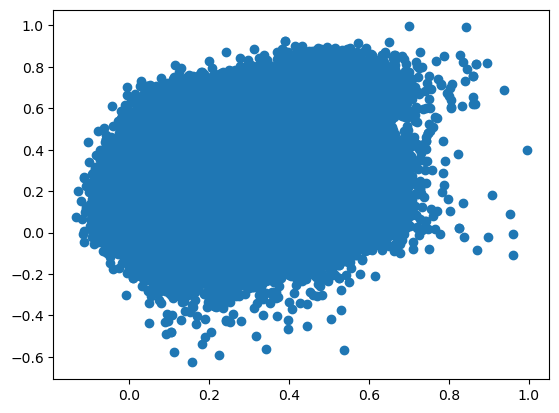

0.18120692308498207 0.0


In [52]:
sample = cor_sim_pairs[np.random.choice(cor_sim_pairs.shape[0], 1000000)]
sample = sample[~np.isnan(sample).any(axis=1)]
sim_score = sample[:, 0]
corr = sample[:, 1]
plt.scatter(sim_score, corr)
plt.show()

import numpy.ma as ma
import scipy
r, p = scipy.stats.pearsonr(sim_score, corr)
print(r, p)

Even though r value is only 0.18, the p value seems like to be very close to 0, even beyond the floating point precision. Therefore, it is safe to say that there is a weak positive correlation between cosine similarities and price correlation.

### 2. Evaluating return predictor model

In [53]:
return_model.eval()
test_y_pred = return_model(test_x)
test_y_pred = test_y_pred.detach().numpy()
test_y = test_y.detach().numpy()


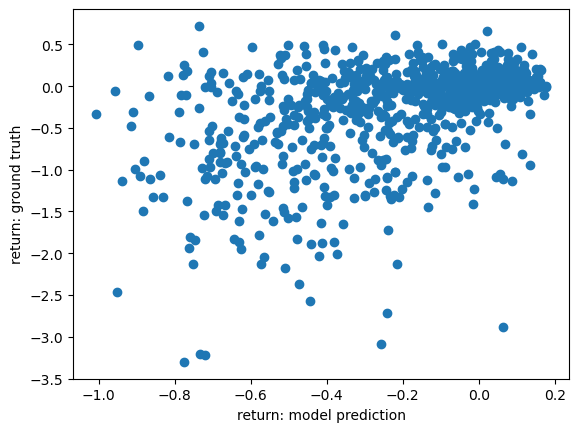

r and p for return prediction: 0.48127712482368173 1.1612971099887852e-55


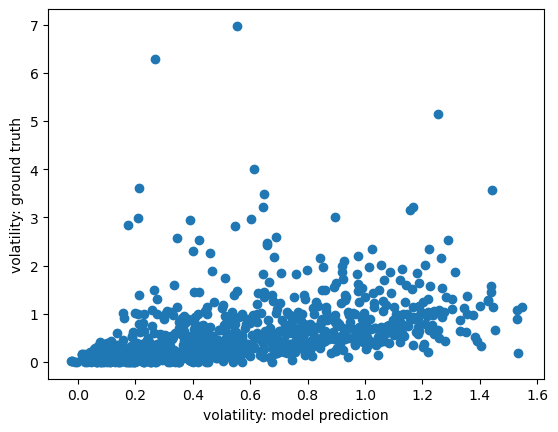

r and p for volatility prediction: 0.43285486743456036 3.302301608389121e-44


In [56]:
plt.scatter(test_y_pred[:, 0], test_y[:, 0])
plt.ylabel("return: ground truth")
plt.xlabel("return: model prediction")
plt.show()

ret_r, ret_p = scipy.stats.pearsonr(test_y_pred[:, 0], test_y[:, 0])
print("r and p for return prediction:", ret_r, ret_p)

plt.scatter(test_y_pred[:, 1], test_y[:, 1])
plt.ylabel("volatility: ground truth")
plt.xlabel("volatility: model prediction")
plt.show()

vol_r, vol_p = scipy.stats.pearsonr(test_y_pred[:, 1], test_y[:, 1])
print("r and p for volatility prediction:", vol_r, vol_p)

Surprisingly, we found a relatively high correlation between predicted and real values, which means that our model can estimate to a certain degree how much they earned in the *past 3 years* from descriptions alone! What does this mean? Does this mean we conquered the stock market?

Unfortunately, no. There is a good chance that *the future information leaked into past*, which makes prediction much easier for the model. When a company updates their description, it overwrites the past one. Therefore, I would need a historical log of description data to truly *forecast* the stock returns.

Yet, this result still implies a fascinating conclusion: we have quantitatively shown that there was a preference to certain group of companies in the last 3 years, making prediction just by description possible! Would they be tech companies? Or biotech? Pharmaceutical? Those questions are outside the scope of this challenge, but they are definitely worth asking.

### Conclusion

1. Semantic Search model: There is a weak but certain correlation between cosine similarity and price correlation. However, this is not the best way to measure the quality of our model; the best way would be asking a group of experts. It seems to be working well intuitively when tested on few examples.
2. Clustering: At least K-means clustering and Gaussian Mixture model did not perform well in the clustering task. One can blame the curse of dimensionality, but there is a possibility that there are simply many companies in the "grey area" that refuses to be clustered with other ones.
3. Price prediction: We found a neural network model can estimate its past 3-year average return and volatility from description embeddings. However, one should not assume that it can predict the future returns as well.



## Level ???: Playground

I decided to provide a space to play with the models. They are pretty fascinating, so give it a try!


In [57]:
semantic_search("I'm going to cure cancer.", top=10, use_pca=False)

[[tensor(0.4335), array(['The Oncology Institute, Inc.',
       'The Oncology Institute, Inc., an oncology company, provides medical oncology services in the United States. Its services include physician services, in-house infusion and dispensary, clinical trial services, radiation, outpatient stem cell transplants and transfusions programs, and patient support. The company also offers and manages clinical trial services, such as managing clinical trials, palliative care programs, and stem cell transplants services. It serves adult and senior cancer patients. The company operates 67 clinic locations. The Oncology Institute, Inc. was founded in 2007 and is based in Cerritos, California.',
       'TOI'], dtype=object)], [tensor(0.4021), array(['Qualigen Therapeutics, Inc.',
       "Qualigen Therapeutics, Inc., a biotechnology company, develops novel therapeutic products for the treatment of cancer and infectious diseases. It offers FastPack, a rapid diagnostic testing system. The company

In [88]:
find_peers_of("AAPL")

[[tensor(0.9996), array(['Apple Inc.',
       'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. In addition, the company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; AirPods Max, an over-ear wireless headphone; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, HomePod, and iPod touch. Further, it provides AppleCare support services; cloud services store services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. Additionally, the company offers various services, such as Apple Arcade, a game subscription service; Apple Music, which offers users a curated listening experience with on-demand radio stations; Apple News+, a subscri

In [91]:
import math
def ask_cyber_Mark_Cuban(string):
    result = return_model(torch.tensor(model.encode(string))).detach().numpy()
    mu, sigma = result[0] / 365 , math.sqrt(result[1] / 365) # daily return, daily volatility
    for i in range(20):
        plt.plot(np.exp(np.cumsum(np.random.normal(mu, sigma, size = 365))))
    plt.title("possible trajectories of your company")
    plt.show()
    print("average log return:", result[0], "average volatility:", result[1])

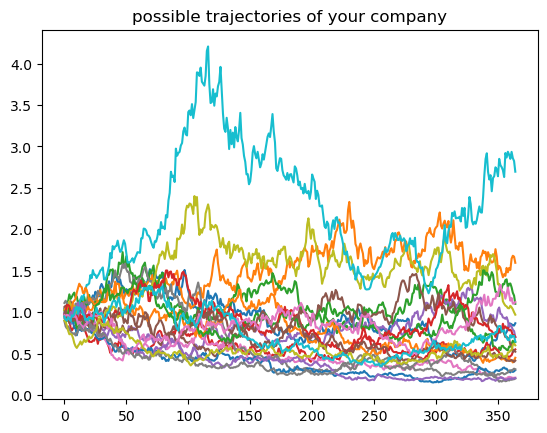

average log return: -0.4222191 average volatility: 0.7867305


In [93]:
ask_cyber_Mark_Cuban("I am going to cure cancer.")